## Set Up ##

In [1]:
#checking where I am
!pwd 

/global/u2/c/chanun/cosmic_voids/doc


In [2]:
#import neccessary libaries
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import mode, skew, kurtosis
%matplotlib inline

In [3]:
#move
%cd

/global/u2/c/chanun


In [4]:
#load unit sims 
ELG = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_ELG_footprint_nz_cutsky_snap102.fits')
QSO = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_QSO_footprint_nz_cutsky_snap102.fits')
LRG = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_LRG_footprint_nz_cutsky_snap102.fits')

In [5]:
#move to scratch
%cd scratch

/global/cscratch1/sd/chanun


In [6]:
#loading in data files

#Zobov voids
south = np.loadtxt('testrevenv/revolver-test/zobov-recon-voids_cat.txt',skiprows=2,unpack=True)
north = np.loadtxt('testrevenv/revolver-test-north/zobov-recon-voids_cat.txt',skiprows=2,unpack=True)

#Voxel voids
voxelsouth = np.loadtxt('testrevenv/revolver-test/voxel-recon-voids_cat.txt',skiprows=2, unpack=True)

#South CMASS galaxies
southgal = Table.read('testrevenv/galaxy_DR12v5_CMASS_South.fits')
northgal = Table.read('testrevenv/galaxy_DR12v5_CMASS_North.fits')

#BOSS DR12 Voids
bossvoids = np.loadtxt('testrevenv/BOSS_DR12_Voids.txt', dtype='str',unpack=True)

#Unitsims
lrg = np.loadtxt('testrevenv/revolver-unitsims-LRG/zobov-recon-voids-LRG_cat.txt',skiprows=2,unpack=True)

## Functions ##

In [7]:
def finddegrees(redshift,effectiverad,cosmology):
    '''Given redshift, physical size, and cosmology we can find the angular diameter distance and angular size'''
    angdiameter = cosmology.angular_diameter_distance(redshift)
    theta = (effectiverad/angdiameter.value)* (180/np.pi) #this is in degrees 
    delta = theta/ np.cos(theta)
    return angdiameter, theta, delta

In [8]:
def fill_between(x, y1, y2=0, ax=None, **kwargs):
    """Plot filled region between `y1` and `y2`. Works exactly the same as matplotlib's fill_between, 
    except that it also plots a proxy artist (specifically, a rectangle of 0 size) 
    so that it can be added to a legend. Adapted from VIDE. """
    ax = ax if ax is not None else plt.gca()
    ax.fill_between(x, y1, y2, interpolate=True, **kwargs)
    p = plt.Rectangle((0, 0), 0, 0, **kwargs)
    ax.add_patch(p)

In [9]:
def numberfunction(radii,volume,labels,bins=100,a1=0.5,a2=0.9,cumulative=True,plot=True):
    ''' Plot a cumulative (or not) number function given a list of radii and volumes (and labels for the legend).
    Returns bincenters, mean, lower and upper bounds as a list within a list. Adapted from VIDE'''
    data = []
    
    if plot:
            plt.clf()
            plt.figure(figsize=(10,8))
            plt.xlabel("$R_{eff}$ [$h^{-1}Mpc$]", fontsize=14)

            if cumulative:
                plt.ylabel(r"log ($n$ (> R) [$h^3$ Gpc$^{-3}$])", fontsize=14)
            else:
                plt.ylabel(r"log ($dn/dR$ [$h^3$ Gpc$^{-3}$])", fontsize=14)
                
    for i in range(0,len(radii)):
        counts, binedges = np.histogram(radii[i], bins=bins)
        bincenters = 0.5*(binedges[1:]+binedges[:-1])
        
        if cumulative:
            cond = False
            for j in range(len(counts)):
                if not cond and counts[j] ==0:
                    continue
                else:
                    cond = True
                    counts[j] = np.sum(counts[j:])
    
        nvoids = len(radii[i])
        var = counts * (1. - counts/nvoids)
        sig = np.sqrt(var)
        vol = volume*10**-9 
        m = np.log10(counts/vol)
        lowerbound = np.log10((counts - sig)/vol)
        upperbound = np.log10((counts + sig)/vol)
    
        #trimming
        trim = (lowerbound > .01)
        m = m[trim]
        bincen = bincenters[trim]
        lower = lowerbound[trim]
        upper = upperbound[trim]
        data.append([bincen,m,lower,upper])
    
                
        if plot:
            fill_between(bincen, lower, upper,alpha=a2,edgecolor='k')
            plt.plot(bincen, m, '-',label=labels[i],alpha=a1)
            plt.legend()
    
    return data 

In [18]:
def plotcdf(datas,labels,bins=100,plot=True,figsize=(8,6)):
    '''Plot the cumulative distribution function and probability distribution function (optional given a list of catalogues.
    Returns cdf, pdf, bincenters (x-axis) respectively. ''' 
    information = []
    
    if plot:
        plt.figure(figsize=figsize)
        
    for i in range(0,len(datas)):
        counts, bincenters = np.histogram(datas[i],bins=bins)
        #bincenters = 0.5*(bincounts[1:]+bincounts[:-1])
        pdf = counts / sum(counts) #probability cdf = np.cumsum(pdf) #adding the probs
        cdf = np.cumsum(pdf)
        information.append([cdf,pdf,bincenters])
        if plot:
            plt.plot(bincenters[1:],cdf, label=f"CDF:{labels[i]}")
            plt.xlabel('$R_{eff}$ [$Mpc/h$]',fontsize=14)
            plt.ylabel('Probability',fontsize=14)
            plt.ylim(0,1.02)
            #if plotboth:
                #plt.plot(bincenters[1:],pdf, label=f"PDF:{labels[i]}")
            plt.legend()
            
    return information

In [11]:
def getstats(data,b=100, plot=True):
    '''Returns mode, mean, std, skew, kurtosis, 25th, 50th, 75th percentile. 
    Skew: measure of asymmetry- 0 for norm dist (no skewness), positive right tail, negative left tail.
    Kurtosis: measure if a dist is heavy-tailed or light-tailed- 0 for normal fisher, positive heavy-tailed (more outliers than norm dist), negative light-tailed'''
    m, mc, a, std, s, k, q, h, f = mode(data)[0][0], mode(data)[1][0], data.mean(), np.std(data), skew(data), kurtosis(data), np.percentile(data,25), np.percentile(data,50), np.percentile(data,75)
    if plot:
        plt.figure(figsize=(10,8))
        plt.hist(data,bins=b,color='deepskyblue')
        plt.axvline(q,linestyle='--',color='k')
        plt.axvline(h,linestyle='--',color='k',label='quartiles')
        plt.axvline(f,linestyle='--',color='k')
        plt.axvline(a,linestyle='--',color='firebrick',label='mean')
        plt.axvline(m,linestyle='--',color='darkorange',label='mode')
        plt.ylabel('Number of Voids',fontsize=14)
        plt.xlabel('$R_{eff}$ [$Mpc/h$]', fontsize=14)
        plt.legend()
        print('mode: {}'.format(m))
        print('mode count: {}'.format(mc))
        print('mean: {}'.format(a))
        print('std: {}'.format(std))
        print('skew: {}'.format(s))
        print('kurtosis: {}'.format(k))
        
    return m, mc, a, std, s, k, q, h, b

In [12]:
def radecz_to_xyz(radecz, cosmo=None):
    """
    radecz - array of RA, Dec (both in decimal degrees), Z

    returns tuple of XYZ in Mpc Cartesian coordinates

    """
    if cosmo is None:
        from astropy.cosmology import FlatLambdaCDM
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    ra, dec, zz = radecz
    dist = cosmo.comoving_distance(zz).value # [Mpc]

    conv = np.pi/180. # convert degrees --> radians
    cos_dec = np.cos(dec*conv)
    x = dist*cos_dec*np.cos(ra*conv)
    y = dist*cos_dec*np.sin(ra*conv)
    z = dist*np.sin(dec*conv)
    
    return np.array([x, y, z]) # [3, N] array

## BOSS Voids ##

In [13]:
maskcmassnorth = (bossvoids[0]=='CMASS') & (bossvoids[1]=='North')
maskcmasssouth = (bossvoids[0]=='CMASS') & (bossvoids[1]=='South')

In [14]:
#col 6: Ngal- number of galaxies in the void
#col 7: V- Voronoi volume of the void
#col 9: n_min- number density of the of the minimum density Vornoi cell in the void
#col 10: delat_min- density contrast of the minimum density cell comparing to the mean desnity of that z
#col 11: r- the ratio between the minimum density particle on a ridge to the minimum density particle in the void
#col 12: P- prob. that the void arises from Poisson fluctuations

bnid = bossvoids[2][maskcmassnorth].astype(float) #id
bnra = bossvoids[3][maskcmassnorth].astype(float) #ra
bndec = bossvoids[4][maskcmassnorth].astype(float) #dec 
bnz = bossvoids[5][maskcmassnorth].astype(float) #redshift, z
bnreff = bossvoids[8][maskcmassnorth].astype(float) #reff
bnd = bossvoids[13][maskcmassnorth].astype(float) #distance form boundary

bsid = bossvoids[2][maskcmasssouth].astype(float)
bsra = bossvoids[3][maskcmasssouth].astype(float)
bsdec = bossvoids[4][maskcmasssouth].astype(float)
bsz = bossvoids[5][maskcmasssouth].astype(float)
bsreff = bossvoids[8][maskcmasssouth].astype(float) 
bsd = bossvoids[13][maskcmasssouth].astype(float)

In [15]:
cmassvoidsreff = np.concatenate((bnreff, bsreff))
cmassvoidsz = np.concatenate((bnz, bsz))
uncut_cmassvoidsreff = np.concatenate((south[4],north[4]))

<Figure size 432x288 with 0 Axes>

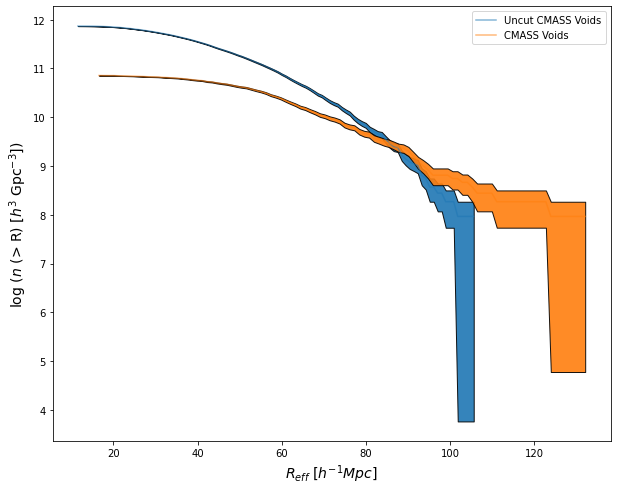

In [16]:
#cumulative number function
a1 = 0.55
vol = 10.8 #10.8 * 10**9 #Gpc3
radii = [uncut_cmassvoidsreff,cmassvoidsreff]
labels = ['Uncut CMASS Voids','CMASS Voids']

#cumulative number function
nf = numberfunction(radii,vol,labels,a1=a1);

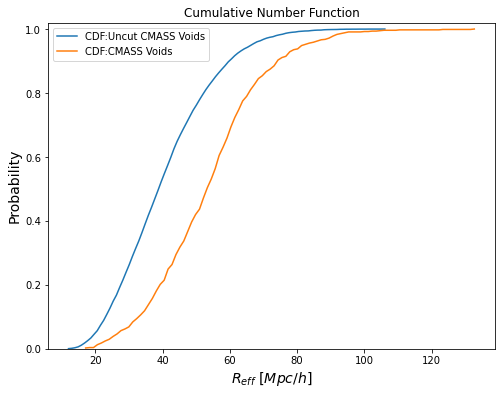

In [19]:
info = plotcdf(datas=radii,labels=labels)
plt.title('Cumulative Number Function');

mode: 41.139
mode count: 2
mean: 53.39460465116279
std: 16.523325454528138
skew: 0.497130221650456
kurtosis: 0.8884692612867999


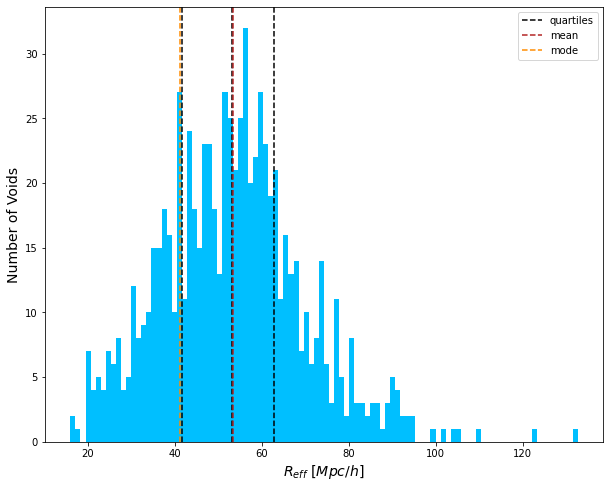

In [20]:
g = getstats(cmassvoidsreff)

Text(0, 0.5, 'Distance to boundary')

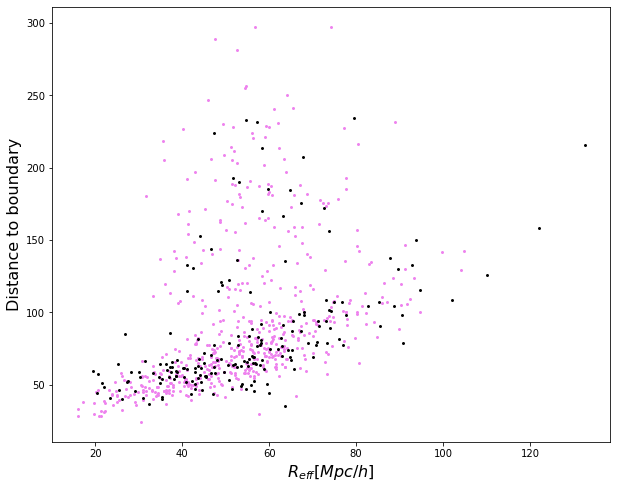

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(bnreff,bnd,s=15,color='violet',marker='.')
plt.scatter(bsreff,bsd,s=15,color='k',marker='.')
plt.xlabel('$R_{eff} [Mpc/h]$',fontsize = 16)
plt.ylabel('Distance to boundary', fontsize = 16)
#plt.ylim(0,180)
#Figure 1